## Intensity filtered data using reference aluminium wavelength 309.506 (pixel number 445) using saturated data

### No preprocessing

In [1]:
import os
from sys import stdout
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [6]:
x_df = pd.read_csv('../avg_base_wl_norm_24-02.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(24, 1446)
(1446,)
24


,252.071400,252.201700,252.331900,252.462200,252.592400,252.722600,252.852900,252.983100,253.113300,253.243600,...,428.718100,428.828600,428.939000,429.049500,429.159900,429.270300,429.380600,429.491000,429.601300,429.711600
0,-0.000051,-0.000137,-0.000348,0.000134,-0.000060,-0.000077,0.000103,0.000288,0.000048,-0.000200,...,0.000521,0.001721,0.004923,0.003764,0.001069,0.000188,-0.000245,-0.000420,-0.000480,-0.000328
1,-0.001003,-0.000983,-0.001484,-0.000547,-0.000816,-0.001066,-0.000582,-0.000177,-0.000701,-0.001171,...,0.000279,-0.000513,-0.000753,-0.000850,-0.000457,-0.000360,-0.001016,-0.001207,-0.001517,-0.001294
2,-0.000341,-0.000526,-0.000959,-0.000165,-0.000454,-0.000580,-0.000363,0.000072,-0.000358,-0.000667,...,0.000353,-0.000297,-0.000363,-0.000443,-0.000008,-0.000071,-0.000568,-0.000726,-0.000842,-0.000741
3,-0.000568,-0.000668,-0.001076,-0.000203,-0.000601,-0.000808,-0.000456,-0.000069,-0.000465,-0.000773,...,0.000238,-0.000381,-0.000311,-0.000482,-0.000088,-0.000271,-0.000807,-0.001016,-0.001190,-0.000999
4,0.000615,0.000247,0.000025,0.000840,0.000589,0.000853,0.001643,0.001616,0.000699,-0.000022,...,0.000197,-0.000316,-0.000706,-0.000500,-0.000089,-0.000213,-0.000574,-0.000726,-0.000858,-0.000666
5,0.000623,0.000112,-0.000077,0.000916,0.000636,0.000809,0.001711,0.001559,0.000529,-0.000098,...,0.000244,-0.000184,-0.000098,-0.000164,-0.000065,-0.000170,-0.000652,-0.000780,-0.000873,-0.000697
6,-0.000550,-0.000641,-0.001207,-0.000107,-0.000427,-0.000747,-0.000301,-0.000033,-0.000588,-0.001100,...,0.000613,-0.000350,-0.000590,-0.000545,-0.000060,-0.000018,-0.000693,-0.000959,-0.001114,-0.000919
7,-0.000210,-0.000352,-0.000602,0.000056,-0.000297,-0.000301,-0.000004,0.000193,-0.000140,-0.000479,...,0.000458,-0.000105,-0.000136,-0.000052,0.000116,0.000011,-0.000311,-0.000540,-0.000697,-0.000556
8,0.000343,0.000048,-0.000111,0.000531,0.000399,0.000530,0.001000,0.001059,0.000538,0.000049,...,0.000453,0.000015,-0.000034,-0.000083,0.000113,0.000099,-0.000159,-0.000174,-0.000329,-0.000161
9,0.000985,0.000507,0.000423,0.001340,0.001131,0.001475,0.002382,0.002284,0.001182,0.000585,...,0.000317,-0.000102,-0.000244,-0.000240,0.000014,0.000034,-0.000183,-0.000354,-0.000428,-0.000289


[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]


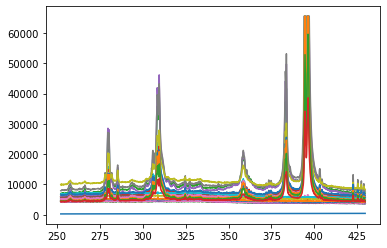

In [7]:
#This is just for visualizing the various plots of the samples

df = pd.read_csv('../ref_new/1.csv')
data=df.values
wl= data[0]
print(wl)

for i in range(len(values)):
    plt.plot(wl, data[i,:])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""



In [8]:
df_y = pd.read_csv('../concentration_1.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(24, 9)


,Reference Number,Si,Fe,Mg,Zn,Cu,Mn,Al,Total
0,1,0.185,0.228,2.940,0.0304,0.0620,0.280,96.0000,99.7254
1,2,0.360,0.600,1.100,0.0700,0.2000,0.830,96.5787,99.7387
2,3,9.140,1.010,0.200,0.4200,3.6000,0.410,84.7770,99.5570
3,4,8.565,0.000,0.293,0.8870,2.6360,0.330,86.5650,99.2760
4,5,9.500,0.000,0.391,0.0000,0.0580,0.016,90.0210,99.9860
5,6,7.220,0.140,0.360,0.0840,0.1200,0.053,91.8090,99.7860
6,7,7.460,0.530,0.036,0.1400,0.1500,0.100,91.4140,99.8300
7,8,12.900,0.120,0.520,0.1550,0.5200,0.286,84.7905,99.2915
8,9,8.750,0.460,1.710,0.0290,2.0000,0.056,85.3100,98.3150
9,10,0.260,0.420,1.260,0.0200,0.0040,1.160,96.8346,99.9586


In [9]:
y_val = concentration[:,3] #1-Si, 2-Fe, 3-Mg, 5-Cu, 6-Mn (4-Zn but too much sparse)
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[2.94  1.1   0.2   0.293 0.391 0.36  0.036 0.52  1.71  1.26  0.41  0.88
 0.32  0.025 0.77  4.54  0.57  0.39  3.57  0.339 0.363 2.48  1.11  2.03 ]
(24,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)
        0
3   8.565
8   8.750
6   7.460
12  6.120
15  0.160


# Principal Components Analysis

In [11]:
n_components=20


x = x_df.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 1446)
(1446,)
24
(24, 20)
[33.46 55.65 67.57 76.52 83.83 87.93 90.57 92.92 94.42 95.9  96.66 97.3
 97.94 98.31 98.64 98.92 99.18 99.36 99.54 99.7 ]


In [12]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation

mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.9085423578441599 -725.4855953165362
1.8448928779905132 14654.741464670386


now using PCA with Linear regression and PLS

In [13]:
n_components=15

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 1446)
(1446,)
19
(19, 15)
[37.31 56.7  68.66 77.53 85.53 89.58 92.49 94.49 96.16 97.13 97.88 98.41
 98.79 99.14 99.45]


In [14]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_p = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_p)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_p)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -0.4986059819848421
MSE:  15.03722822249731


37% completed
Suggested number of components:  1



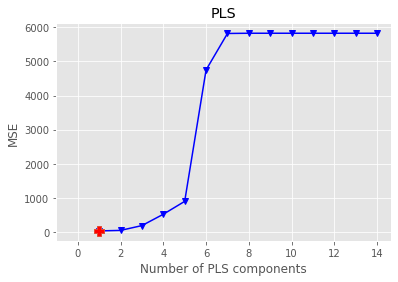

R2 calib: 0.806
R2 CV: -0.343
MSE calib: 4.290
MSE CV: 29.656


In [15]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [16]:
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -0.4986059819848421
MSE:  15.03722822249731


# Linear Regression
this is ordinary least square regression

R^2_pred:  -1.4888826762226075
RMSE:  4.997380030808445 

[real, predictions]
[[ 8.565       5.05028646]
 [ 8.75       -1.04057431]
 [ 7.46        5.67757406]
 [ 6.12        9.09782987]
 [ 0.16        2.30847999]]


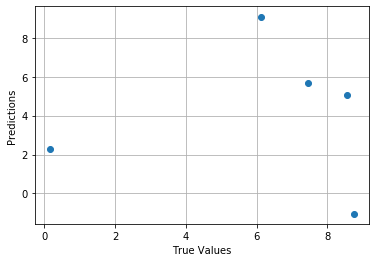

In [17]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("R^2_pred: ", r2)
print("RMSE: ", rmse, "\n")


b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Partial Least Square Regression

## No preprocessing

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)
y_test

(19, 1446) (19, 1)
(5, 1446) (5, 1)


,0
7,12.900
0,0.185
20,6.160
12,6.120
14,0.530


100% completed
Suggested number of components:  1



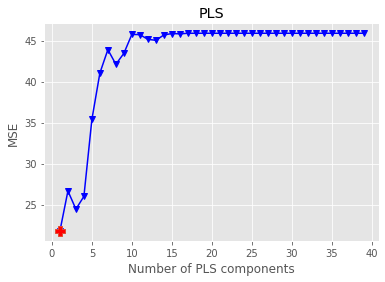

R2 calib: 0.260
R2 CV: -0.080
MSE calib: 14.921
MSE CV: 21.778


In [19]:
optimise_pls_cv(x_df, y_df, 40, plot_components=True)
#optimise_pls_cv(x_df, y_all, 40, plot_components=True)

In [20]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_df, y_df)
# Cross-validation
y_cv = cross_val_predict(pls, x_df, y_df, cv=10)
# Calculate scores
score = r2_score(y_df, y_cv)
mse = mean_squared_error(y_df, y_cv)

print("R^2_cv", score)
print("MSE: ", mse)

R^2_cv -0.21138029881074694
MSE:  24.436086839040144


100% completed
Suggested number of components:  4



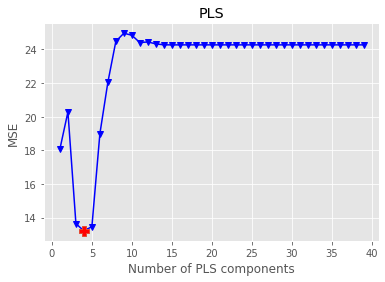

R2 calib: 0.835
R2 CV: 0.330
MSE calib: 3.261
MSE CV: 13.205


In [21]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  -0.6016863172928415
R2_cv:  0.30821348934193693

TEST
 [real, predictions]
[[12.9         2.93418579]
 [ 0.185       6.18154731]
 [ 6.16        8.07847924]
 [ 6.12        9.06590426]
 [ 0.53        5.56697057]]



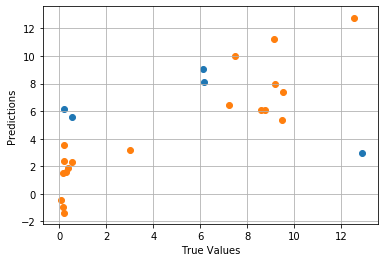

In [22]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [23]:
print(wl.shape)

(1446,)


## Wavelenght selection for PLS

In [10]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  10
Wavelengths to be discarded  1398
Optimised MSEP  0.2028500473060817

--- 345.0111644268036 seconds ---


sorted wavelengths:  [377.6465 332.7805 334.1599 397.4301 314.5958 427.3902 395.4412 381.3587
 281.5262 397.1964]


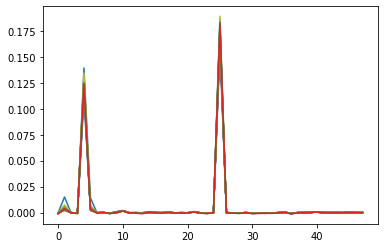

In [11]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [51]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 48) (19, 1)
(5, 48) (5, 1)
        0
10  0.410
15  4.540
21  2.480
3   0.293
17  0.390


17% completed
Suggested number of components:  6



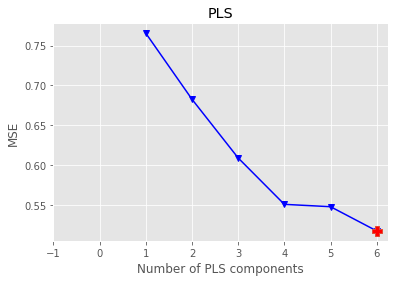

R2 calib: 0.984
R2 CV: 0.425
MSE calib: 0.015
MSE CV: 0.517


In [52]:
optimise_pls_cv(X_train,y_train, 7, plot_components=True)

R2_pred:  0.5445638176438561
RMSE:  1.1294140576425928

TEST
 [real, predictions]
[[0.41       1.02705676]
 [4.54       2.25242162]
 [2.48       1.65861465]
 [0.293      0.39901763]
 [0.39       0.66963016]]



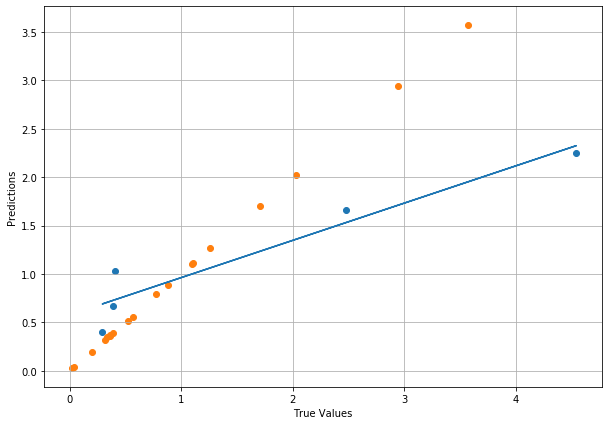

In [67]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [54]:
Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)
print(Xn_train.shape)
print(Xn_test.shape)

(19, 48)
(5, 48)


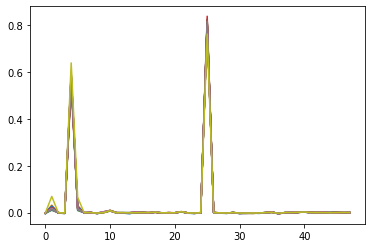

In [55]:
plt.plot(Xn_train.T)
plt.show()

17% completed
Suggested number of components:  6



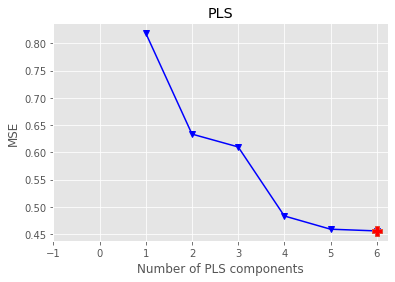

R2 calib: 0.982
R2 CV: 0.494
MSE calib: 0.016
MSE CV: 0.456


In [56]:
#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
optimise_pls_cv(Xn_train,y_train, 7, plot_components=True)

R2_pred:  0.6185664476633523
RMSE:  1.0335913595503912

TEST
 [real, predictions]
[[0.41       1.12115019]
 [4.54       2.46340706]
 [2.48       1.81746956]
 [0.293      0.35678479]
 [0.39       0.67384427]]



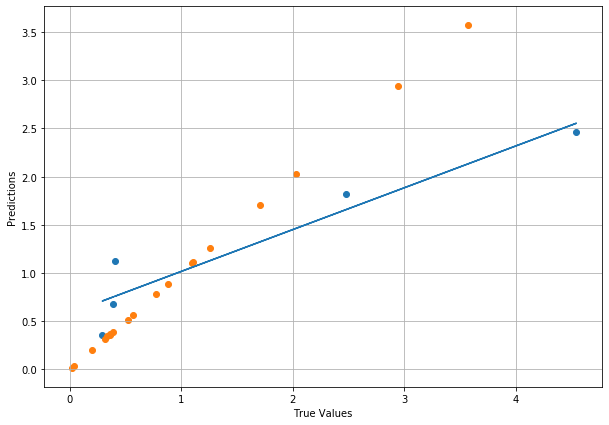

In [69]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using SNV

(19, 48)
(5, 48)
17% completed
Suggested number of components:  6



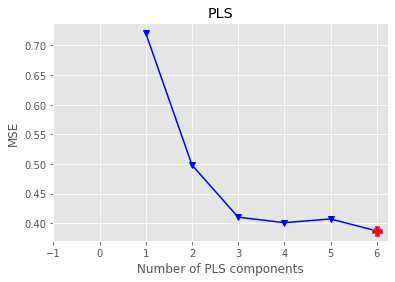

R2 calib: 0.977
R2 CV: 0.570
MSE calib: 0.020
MSE CV: 0.387


In [58]:
Xs_train = snv(X_train)
Xs_test = snv(X_test)
print(Xs_train.shape)
print(Xs_test.shape)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
optimise_pls_cv(Xs_train,y_train, 7, plot_components=True)

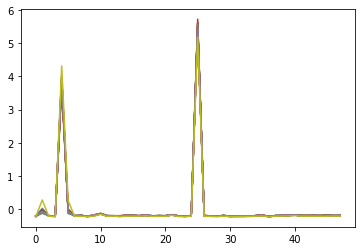

In [59]:
plt.plot(Xs_train.T)
plt.show()

R2_pred:  0.7095499692878418
RMSE:  0.9019347859939593

TEST
 [real, predictions]
[[0.41       1.01848246]
 [4.54       2.95755918]
 [2.48       1.43735131]
 [0.293      0.57653066]
 [0.39       0.54986247]]



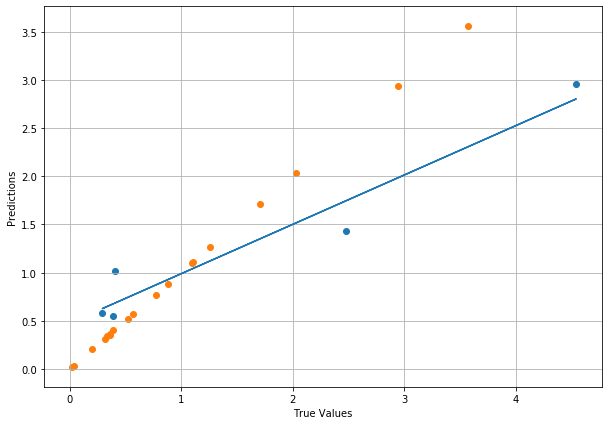

In [60]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(Xs_train, y_train)

y_pred = pls.predict(Xs_test)
y_pred1 = pls.predict(Xs_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Max-norm

17% completed
Suggested number of components:  6



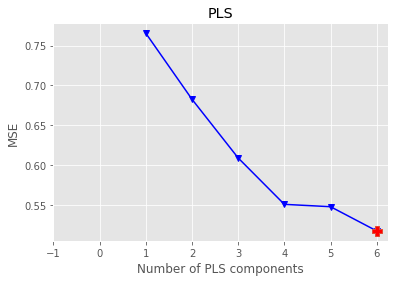

R2 calib: 0.984
R2 CV: 0.425
MSE calib: 0.015
MSE CV: 0.517


In [61]:
Xm_train = X_train / np.max(X_train)
Xm_test = X_test / np.max(X_test)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
optimise_pls_cv(Xm_train,y_train, 7, plot_components=True)

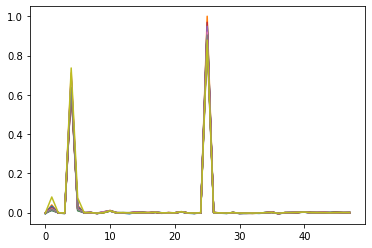

In [62]:
plt.plot(Xm_train.T)
plt.show()

R2_pred:  0.5542803489050647
RMSE:  1.1173013275311223

TEST
 [real, predictions]
[[0.41       1.03938893]
 [4.54       2.27977183]
 [2.48       1.67868717]
 [0.293      0.40365257]
 [0.39       0.67758172]]



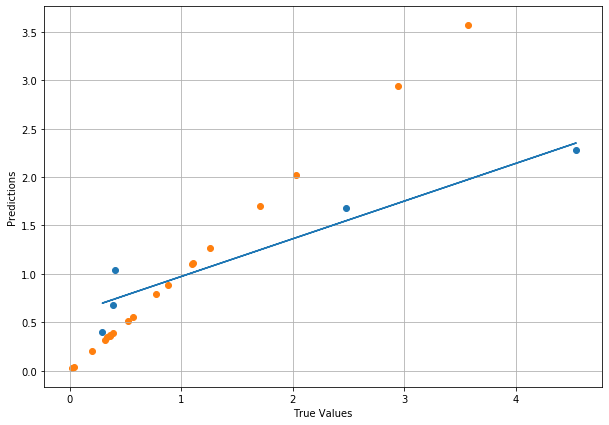

In [65]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(Xm_train, y_train)

y_pred = pls.predict(Xm_test)
y_pred1 = pls.predict(Xm_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [80]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)


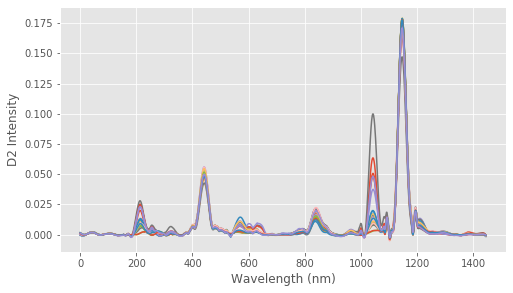

100% completed
Suggested number of components:  3



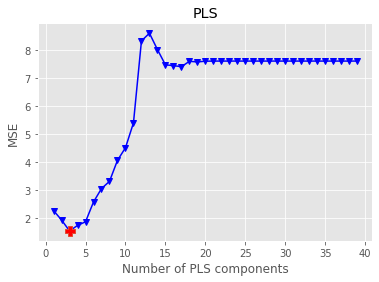

R2 calib: 0.476
R2 CV: -0.131
MSE calib: 0.716
MSE CV: 1.544


In [81]:
# Calculate second derivative
X2 = savgol_filter(x_df, 101, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    
    
X2_1 = msc(X2)[0]
    
optimise_pls_cv(X2_1, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  2



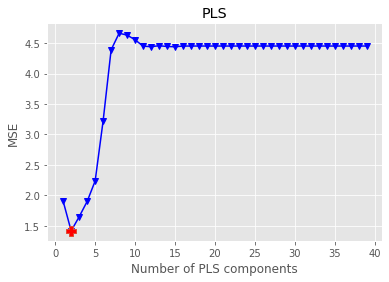

R2 calib: 0.620
R2 CV: -0.120
MSE calib: 0.481
MSE CV: 1.417


In [86]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=1) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=1) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  -0.4142851041406448
R2_cv:  -0.502517109222492

[real, predictions]
[[ 0.339      -0.72308828]
 [ 3.57        0.70202523]
 [ 0.2         0.71243987]
 [ 0.293       1.80524588]
 [ 0.363      -0.11310216]]


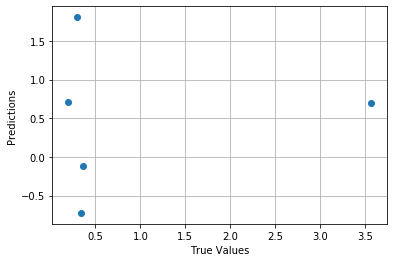

In [87]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(X2_train, y_train)

y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [49]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [50]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.31, MSE:2.86, RMSE:1.69
Alpha:0.0010, R2:0.06, MSE:2.69, RMSE:1.64
Alpha:0.0100, R2:0.00, MSE:2.67, RMSE:1.63
Alpha:0.1000, R2:0.00, MSE:2.67, RMSE:1.63
Alpha:0.3000, R2:0.00, MSE:2.67, RMSE:1.63
Alpha:0.5000, R2:0.00, MSE:2.67, RMSE:1.63
Alpha:0.7000, R2:0.00, MSE:2.67, RMSE:1.63
Alpha:1.0000, R2:0.00, MSE:2.67, RMSE:1.63


In [53]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.30735234558204294
RMSE:  1.692288364509511
R^2:  -0.14336631154891522


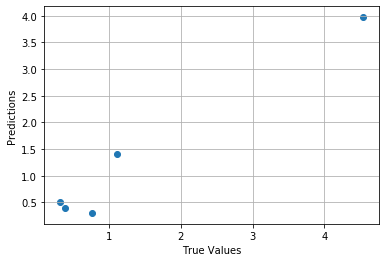

In [52]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [24]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(20, 20) (20, 1)
(4, 20) (4, 1)


In [25]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(4,)
(20,)


RMSE:  4.0536884409757015
R^2:  -10.677988790263843 

[real, predictions]
[[3.      3.40154]
 [0.53    5.28668]
 [0.07    4.19444]
 [0.26    5.35228]]


Text(0, 0.5, 'Predictions')

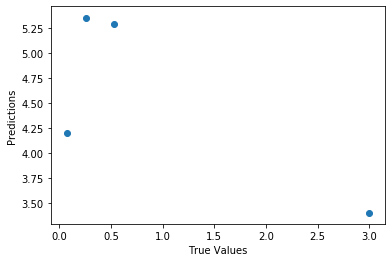

In [27]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 250, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

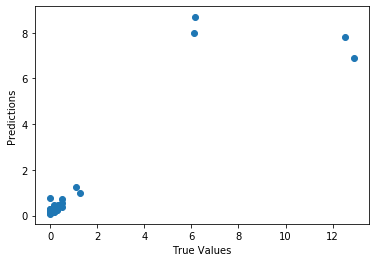

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



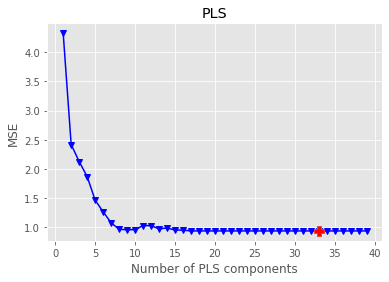

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,7.84,0.22,0.54,0.19,0.57,0.27
1,8.62,0.12,0.35,0.06,-0.12,-0.06
2,10.50,0.13,-0.61,0.45,0.15,-0.03
3,-0.28,0.42,1.56,-0.11,-0.34,0.95
4,9.93,0.09,0.29,-0.26,0.65,0.14


In [152]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
20,6.16,0.00,0.36,0.00,0.01,0.21
12,6.12,0.00,0.32,0.00,0.01,0.02
13,12.53,0.31,0.02,0.05,0.06,0.03
22,0.18,0.50,1.11,0.05,0.15,1.26
7,12.90,0.12,0.52,0.16,0.52,0.29
